# Application 1

## Initialization

### Imports

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Global variables

In [3]:
IMG_NAME = "lancelot_2.jpeg"

## UTILS DEFINITION

### Load the image

In [4]:
def load_img(img_name):
    img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE) #preferably grayscale
    assert img is not None, "Image not found"

    h, w = img.shape
    print("Image size:", w, "x", h)
    return img

### SIFT detector Creation

In [ ]:
# Default values proposed by David Lowe in the original SIFT
sift = cv2.SIFT_create(
    contrastThreshold=0.04,  # remove low-contrast keypoints and unstable extrema in flat regions
    edgeThreshold=10, # removes keypoints lying on edges (poorly localized in one direction)
    sigma=1.6
)

# edgeThreshold=10
# Along an edge, small shifts produce large appearance changes
# SIFT analyzes the Hessian matrix at the keypoint
# If one eigenvalue is much larger than the other -> edge-like structure -> rejected
# Smaller value : more aggressive edge rejection
# Larger value : more edge points kept


'\nedgeThreshold=10\nAlong an edge, small shifts produce large appearance changes\nSIFT analyzes the Hessian matrix at the keypoint\nIf one eigenvalue is much larger than the other -> edge-like structure -> rejected\nSmaller value : more aggressive edge rejection\nLarger value : more edge points kept\n'

Parameters of the SIFT detector : a large number of keypoints are primary detected with SIFT, those parameters act like filters to reduce the total number of keypoints detected in the output.

- contrastThreshold: to remove low contrasted points, comparing this threshold to the DoG (Difference of Gaussian) value.
- edgeThreshold: remove the points on the shapes (points characterized by a single direction - bad localisation)

### Weak extrema removal

In [6]:
def remove_weak_keypoints(keypoints):
    # Extract responses (approximate DoG strength)
    responses = []
    for kp in keypoints:
        responses.append(kp.response) # kp.response = strength of the detected extremum
    responses = np.array(responses)
    print(f"Number of keypoints: {len(responses)}")

    # Chosen strategy : percentage-based filtering (more robust)
    threshold = np.percentile(responses, 70)  # keep top 30%, more robust than fixed threshold

    strong_kps = []
    for kp in keypoints:
        if kp.response >= threshold:# only the top 30% strongest keypoints survive (relative to the threshold value)
            strong_kps.append(kp)

    print("Strong keypoints retained:", len(strong_kps))

### Visualisation

In [7]:
def visualize_keypoints(image, keypoints, window_name="Keypoints"):
    img_kp = cv2.drawKeypoints(
        image,
        keypoints,
        None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    plt.figure(figsize=(14, 6))
    plt.imshow(img_kp, cmap="gray")
    plt.axis("off")
    plt.show()

### Main function

In [8]:
def main_run(image, sift=sift):
    keypoints, descriptors = sift.detectAndCompute(image, None) # descriptors = array of shape Number of keypoints x 128
    print("Number of keypoints detected:", len(keypoints))
    
    remove_weak_keypoints(keypoints)
    visualize_keypoints(image, keypoints)

## Functions application

### Standard

Image size: 500 x 667
Number of keypoints detected: 415
Number of keypoints: 415
Strong keypoints retained: 125


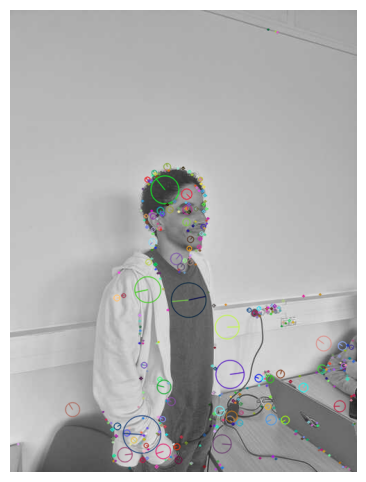

In [9]:
image = load_img(IMG_NAME)
main_run(image)

### Gaussian blur

Image size: 500 x 667
Number of keypoints detected: 209
Number of keypoints: 209
Strong keypoints retained: 63


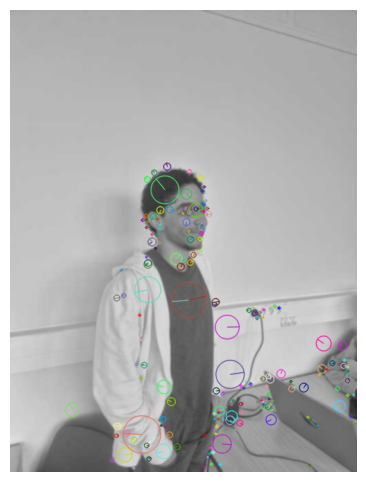

In [10]:
image = load_img(IMG_NAME)
img_blur = cv2.GaussianBlur(image, (5,5), 1.0)
main_run(img_blur)

Image size: 500 x 667
Number of keypoints detected: 562
Number of keypoints: 562
Strong keypoints retained: 169


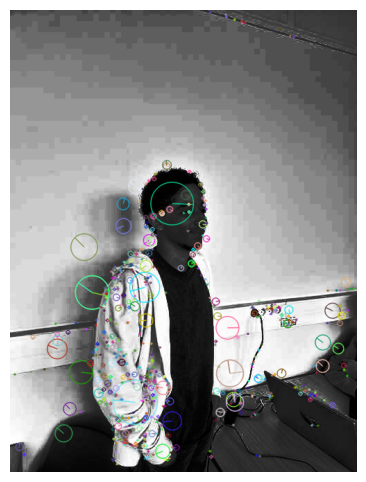

In [11]:
image = load_img(IMG_NAME)
img_eq = cv2.equalizeHist(image)
main_run(img_eq)

## Questions

**Q:** Where are keypoints concentrated? (position, scale and orientation)

**A:** The keypoints are concentrated on details of the image. For example it could be text, reflect of light, distinct shapes (cables, fold of clothes, etc...) or even a contrast between shadows. 

<br>

**Q:** What happens when the object is texture-poor?

**A:** No keypoints are identified in the area or the poor-textured object.

<br>

**Q:** After gaussian blur?

**A:** The gaussian blur smooth the areas of the image. The contrast is lower than in the original image and the details more difficult to identify. A low number of keypoints are identified in the blur image compare tot he normal image (209 against 415 for the all keypoints identified and 63 against 125 for the strong keypoints).

<br>

**Q:** After histo equalization?

**A:** The histogram equalization have the opposite effect of the Gaussian blur, meaning that this transformation enhance the contrast of the image. The enhanced contrast allow us to rise the number of points of interest in the image. For example, a blur shadow in the original image can here become significant. We can expect that the number of keypoint identified is larger than in the original image. After applying the transformation we have identified 562 keypoints and 169 strong keypoints (after weak extrema removal) against 415 and 125 for the original image.

<br>

**Q:** Where in the code you determine the radius of a keypoint (radius= scale)?

**A:** Nowhere explicitly, the radius of each keypoint is determine into the SIFT detector application on the image. During the algorithm application, the radius is determine during the algorithm application (pyramid construction - Gaussian scale space, Difference of Gaussian (DoG) calculation, detection of keypoints).

<br>

**Q:** And why do circles differ in size?

**A:** Because the keypoints are detected in differents scales. If a circle is little, it means that the keypoint has been detected at low scale, and if the circle is big, the keypoint has been detected at a larger scale. This scale property allow to SIFT to be scale invariant, it means that a same point in the image is recognize even if the image is zoomed or dezoomed : useful to compare a same point in two different (but similar) images. 

Rotation / scale robustness check

Example of possible variations:

- rotate or resize the image
- re-detect keypoints

Expectations:
- Similar number of keypoints
- Consistent orientations and scales


In [12]:
# --------------------------------------------------
# Rotate image by X degrees (between 0 and 360)
# --------------------------------------------------
def rotate_img(img, angle):
    h, w = img.shape
    angle = angle
    center = (w // 2, h // 2)

    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    img_rot = cv2.warpAffine(
        img,
        rotation_matrix,
        (w, h),
        flags=cv2.INTER_LINEAR
    )
    return img_rot

Image size: 500 x 667
Number of keypoints detected: 397
Number of keypoints: 397
Strong keypoints retained: 120


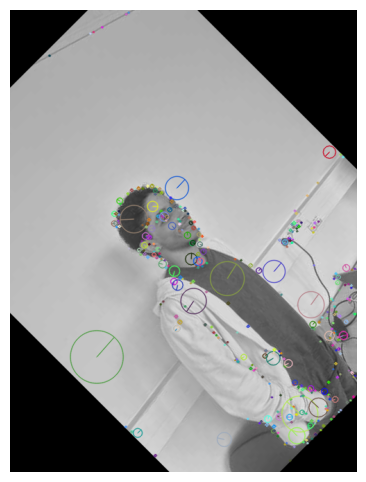

In [13]:
image = load_img(IMG_NAME)
img_rot = rotate_img(image, 45)
main_run(img_rot)

After the rotation, the number of keypoints identified is quite similar to the original image. the rotate image get 397 keypoints detected and 120 strong keypoints detected (415 and 125 for the original image). It is interresting to note that even if the total number of keypoint is different, the number of strong detected keypoints is very close to the original image (120 vs 125).

# Application 2

## Main transformations and calculations

### Utils

In [14]:
def draw_keypoints(img, sift):
    kp, des = sift.detectAndCompute(img, None)

    img_kp = cv2.drawKeypoints(
        img,
        kp,
        None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    return img_kp, kp, des

## Main pipeline 

In [29]:
# Default values proposed by David Lowe in the original SIFT
sift = cv2.SIFT_create(
    contrastThreshold=0.04,  # remove low-contrast keypoints and unstable extrema in flat regions
    edgeThreshold=10, # removes keypoints lying on edges (poorly localized in one direction)
    sigma=1.6
)

In [52]:
"""
Parameters : 
img_name_1 : name of the first image
img_name_2 : name of the second image
k : number of closest neighboors kept after the algorithm application
N : number of best mathes : 5,10,20,30... or None (all the matches)
ratio_threshold : scalar value (between 0 and 1) that controls how distinct the best match must be compared to the second-best match.
"""
def main_sift_lowe(img_name_1, img_name_2, k, N, ratio_threshold = 0.75):
    ### Imgs loading + sift detection
    image_1 = load_img(img_name=img_name_1)
    img_1_kp, kp_1, des_1 = draw_keypoints(image_1, sift)

    image_2 = load_img(img_name=img_name_2)
    img_2_kp, kp_2, des_2 = draw_keypoints(image_2, sift)

    
    ### Retrieve candidate matches using k-nearest neighbor search (k = 2)
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches_knn = bf.knnMatch(des_1, des_2, k=k) 
    print(f"Initial candidate matches (k-NN): {len(matches_knn)}")

    ### Lowe's ratio test (relative similarity) - reject ambiguous matches
    ratio_threshold = ratio_threshold
    good_matches = []

    for m, n in matches_knn:
        if m.distance < ratio_threshold * n.distance:
            good_matches.append(m)

    print(f"Matches after Lowe's ratio test: {len(good_matches)}")


    ### Keep only the N ( 5, 10, 20, 30, 50...) best matches (lowest distance)
    good_matches = sorted(good_matches, key=lambda x: x.distance)
    top_matches = good_matches[:N]


    ### Visualisation
    if N is None :
        print("Visualization of all correct matches")
        top_matches = good_matches
    else :
        print(f"Visualizing top {len(top_matches)} matches")

    img_matches = cv2.drawMatches(
        image_1, kp_1,
        image_2, kp_2,
        top_matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure(figsize=(14, 6))
    plt.imshow(img_matches, cmap="gray")
    plt.title(f"SIFT matching with k-NN (k=2) + Lowe's ratio test + {N} best matching")
    plt.axis("off")
    plt.show()
        
    
    

Image size: 500 x 667
Image size: 500 x 667
Initial candidate matches (k-NN): 232
((< cv2.DMatch 000001AC72DF2C50>, < cv2.DMatch 000001AC72DF27B0>), (< cv2.DMatch 000001AC72DF29D0>, < cv2.DMatch 000001AC72DF2330>), (< cv2.DMatch 000001AC72DF28B0>, < cv2.DMatch 000001AC72DF27D0>), (< cv2.DMatch 000001AC72DF2750>, < cv2.DMatch 000001AC72DF2730>), (< cv2.DMatch 000001AC72DF29F0>, < cv2.DMatch 000001AC72DF2910>), (< cv2.DMatch 000001AC72DF26B0>, < cv2.DMatch 000001AC72DF2990>), (< cv2.DMatch 000001AC72DF2C30>, < cv2.DMatch 000001AC72DF2C10>), (< cv2.DMatch 000001AC72DF2BF0>, < cv2.DMatch 000001AC72DF2BD0>), (< cv2.DMatch 000001AC72DF2BB0>, < cv2.DMatch 000001AC72DF2B90>), (< cv2.DMatch 000001AC72DF2B70>, < cv2.DMatch 000001AC72DF28F0>), (< cv2.DMatch 000001AC72DF2B30>, < cv2.DMatch 000001AC72DF2B10>), (< cv2.DMatch 000001AC72DF2890>, < cv2.DMatch 000001AC72DF2670>), (< cv2.DMatch 000001AC72DF26D0>, < cv2.DMatch 000001AC72DF2650>), (< cv2.DMatch 000001AC72DF2310>, < cv2.DMatch 000001AC72DF2

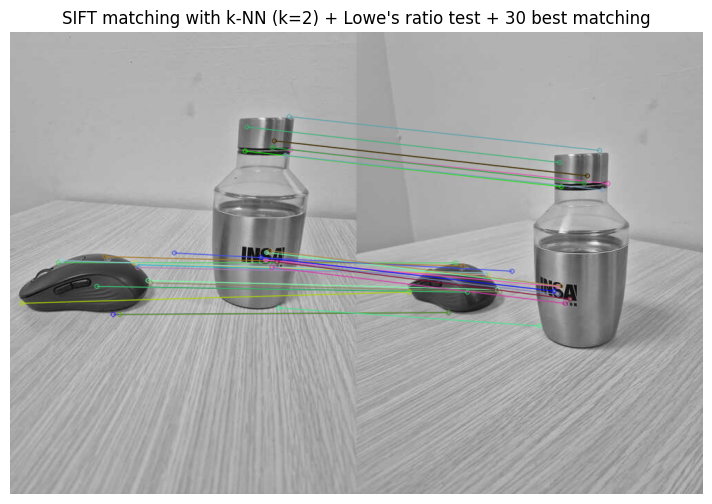

In [45]:
main_sift_lowe(img_name_1="gourde_souris_1.jpeg", img_name_2="gourde_souris_2.jpeg", k=2, N=30)

## Questions & Observations

**Q:** What happens when contrastThreshold is too low / too high?

**A:** If it is to low: there will be a large amount of false positive detected by the SIFT detector due to low contrasted points, and an increased sensibility of the detector.

<br>

**Q:** Why do edges dominate when edgeThreshold is large?

**A:** the edgeThreshold parameter is used to filter the points on the edges. Having a to high edgeThreshold does not filter the edge points anymore. The edges will then be over represented in the detected points, and it is better to avoid this edges over representation.

<br>

**Q:** How does the scale (sigma) affect small vs large structures?

**A:** The sigma parameter influence the blur applied to the image before the detection of points. A small sigma will allow the detection of little details and local information, when a large sigma may be used to identify general shape and larger structure in an image.


### Naïve Descriptor Matching

In [54]:
"""
---- Without Lowe's ratio test. ----
Parameters : 
img_name_1 : name of the first image
img_name_2 : name of the second image
k : number of closest neighboors kept after the algorithm application
N : number of best mathes : 5,10,20,30... or None (all the matches)
ratio_threshold : scalar value (between 0 and 1) that controls how distinct the best match must be compared to the second-best match.
"""
def main_sift(img_name_1, img_name_2, k, N, ratio_threshold = 0.75):
    ### Imgs loading + sift detection
    image_1 = load_img(img_name=img_name_1)
    img_1_kp, kp_1, des_1 = draw_keypoints(image_1, sift)

    image_2 = load_img(img_name=img_name_2)
    img_2_kp, kp_2, des_2 = draw_keypoints(image_2, sift)

    
    ### Retrieve candidate matches using k-nearest neighbor search (k = 2)
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches_knn = bf.knnMatch(des_1, des_2, k=k) 
    print(f"Initial candidate matches (k-NN): {len(matches_knn)}")

    good_matches = [m[0] for m in matches_knn]

    ### Keep only the N ( 5, 10, 20, 30, 50...) best matches (lowest distance)
    good_matches = sorted(good_matches, key=lambda x: x.distance)
    top_matches = good_matches[:N]


    ### Visualisation
    if N is None :
        print("Visualization of all correct matches")
        top_matches = good_matches
    else :
        print(f"Visualizing top {len(top_matches)} matches")

    img_matches = cv2.drawMatches(
        image_1, kp_1,
        image_2, kp_2,
        top_matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure(figsize=(14, 6))
    plt.imshow(img_matches, cmap="gray")
    plt.title(f"SIFT matching with k-NN (k=2) + Lowe's ratio test + {N} best matching")
    plt.axis("off")
    plt.show()
        
    
    

Image size: 500 x 667
Image size: 500 x 667
Initial candidate matches (k-NN): 232
Visualization of all correct matches


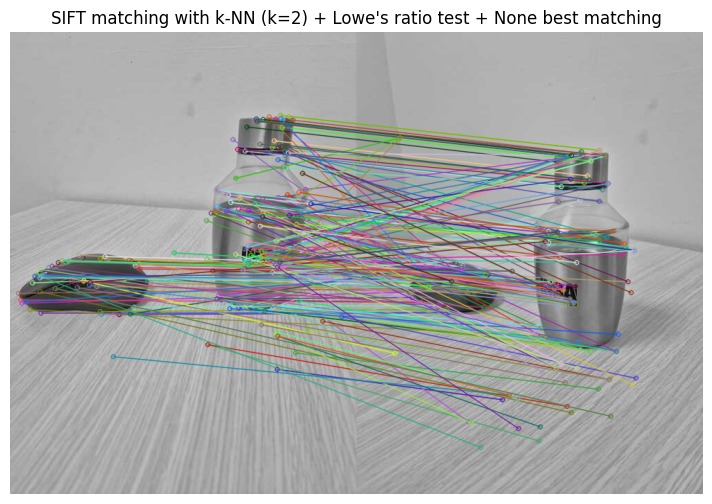

In [57]:
main_sift(img_name_1="gourde_souris_1.jpeg", img_name_2="gourde_souris_2.jpeg", k=1, N=None)

Image size: 500 x 667
Image size: 500 x 667
Initial candidate matches (k-NN): 480
Visualization of all correct matches


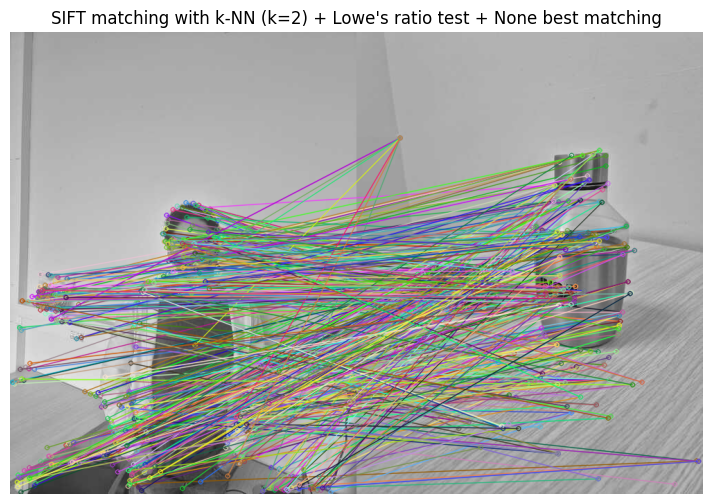

In [58]:
main_sift(img_name_1="lancelot_1.jpeg", img_name_2="gourde_souris_2.jpeg", k=1, N=None)

#### Observations to report

Match two images of the same object
- Number of matches: 232
- Visual coherence of matches: The points seems to be related. A point in the first image is coupled to imself into the second image.
- Presence of clearly incorrect correspondences: Not really, it is hard to say. The only remarkable approximation is about the table (present in the two pictures) and the lines of this tables which can lead to some mistakes. 

<br>

Match two images of different objects
- Number of matches: 480
- Visual coherence of matches: No coherence, maybe only some shape of local edges, the two pictures have nothing in common.
- Presence of clearly incorrect correspondences: There are only inccorrect correspondances. The detector find meaningless similarities : the lowe's test may help us to delete those meaningless matches. 


**Q:** Why do visually similar regions produce false
matches?

**A:** Like in the first example, with the table, similar region may lead to false matches because the identified points are similar, and images are differents.

<br>

**Q:** Why does a small distance not guarantee
correctness?

**A:** Because a small distance is significant only in a mathematic point of view. Often, the mathematical reality is relevant, but it can also lead to false matches because two points mathematically close, share only some characteristics, it does not mean that those points are the same.

<br>


### Lowe’s Ratio Test as a Disambiguation Tool

Image size: 500 x 667
Image size: 500 x 667
Initial candidate matches (k-NN): 232
Matches after Lowe's ratio test: 12
Visualization of all correct matches


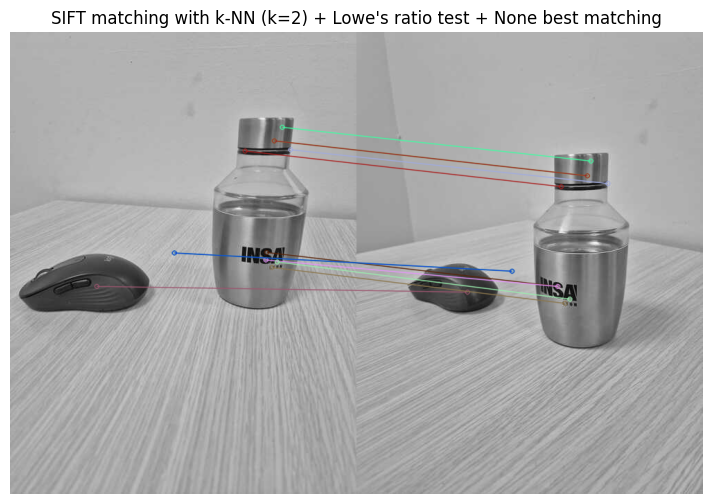

In [64]:
# threshold : 0.6
main_sift_lowe(img_name_1="gourde_souris_1.jpeg", img_name_2="gourde_souris_2.jpeg", k=2, N=None, ratio_threshold=0.6)

Image size: 500 x 667
Image size: 500 x 667
Initial candidate matches (k-NN): 232
Matches after Lowe's ratio test: 37
Visualization of all correct matches


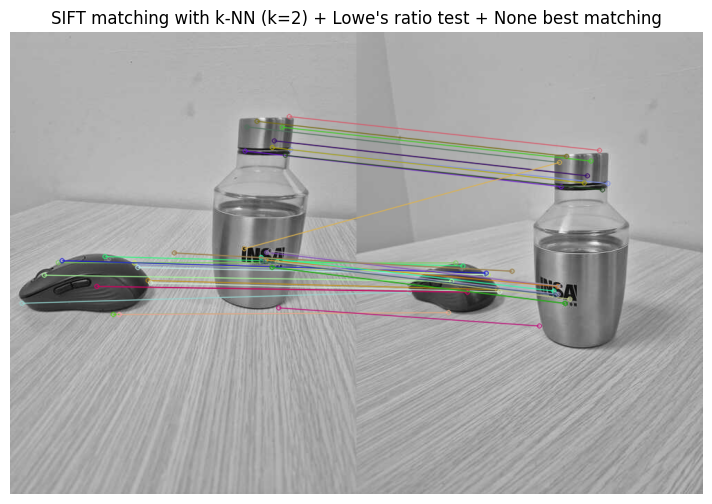

In [62]:
# threshold : 0.75
main_sift_lowe(img_name_1="gourde_souris_1.jpeg", img_name_2="gourde_souris_2.jpeg", k=2, N=None, ratio_threshold=0.75)

Image size: 500 x 667
Image size: 500 x 667
Initial candidate matches (k-NN): 232
Matches after Lowe's ratio test: 100
Visualization of all correct matches


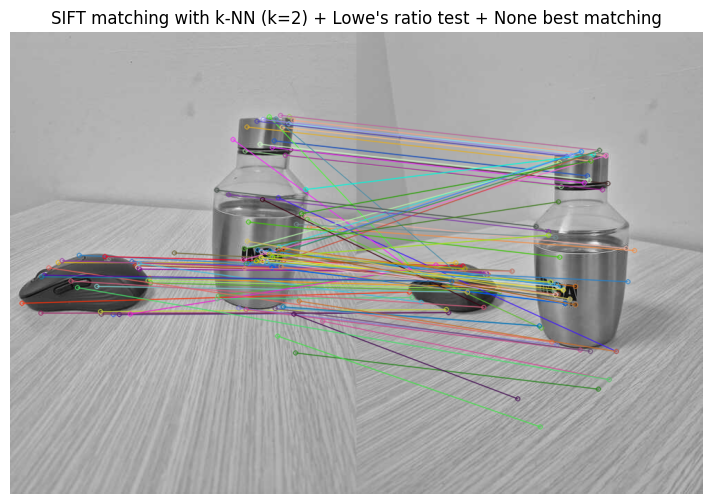

In [63]:
# threshold : 0.9
main_sift_lowe(img_name_1="gourde_souris_1.jpeg", img_name_2="gourde_souris_2.jpeg", k=2, N=None, ratio_threshold=0.9)

For each of the tested threshold, the qualitative correctness is pretty good, there are no big hallucinations, but it seems the lowest the threshold is, the more accurate the detection is.
The threshold have an influence on the number of points kept after the Lowe's ratio test.

**Q:** Why does a stricter ratio remove ambiguous
matches?

**A:** Because a stricter ratio will keep only the lowest distance identified by the detector. The lowest distance have lower chances to be false matches, unless the images are too diferents.

<br>

**Q:** Why does a loose ratio accept false positives?

**A:** The ratio is a criteria to choose to keep points depending on the distance values, there is no notion of false positive and meaning, this is just a mathematic operation.

<br>

**Q:** Why does the ratio test fail in repetitive textures?

**A:** Because points identified in repetitive textures may be very close, and so having a very low distance. The ratio will then keep those points.

<br>

**Q:** Why are many matches geometrically
impossible?

**A:** Because of three main factors : 
- the switch of scale and perspective : it is harder to detect a large number of matches in very different images of the same object. 
- repetitive pattern: large number of false matches in repetitive patterns
- Noise in the image: increase the number of false positive and make the detection harder to perform (sometimes, image pre-processing can help to reduce the noise, but still...)

<br>

**Q:** Why does illumination affect gradient
histograms?

**A:** SIFT descriptor are based on local descriptor histograms. The illumnation may affect the gradient value and parasite the histograms with multiple factors: over exposition, under exposition, reflects or saturation.

<br>


# Application 3

In [75]:
"""
Parameters : 
img_name_1 : name of the first image
img_name_2 : name of the second image
k : number of closest neighboors kept after the algorithm application
N : number of best mathes : 5,10,20,30... or None (all the matches)
ratio_threshold : scalar value (between 0 and 1) that controls how distinct the best match must be compared to the second-best match.
"""
def main_sift_lowe_ransac(img_name_1, img_name_2, k, N, ratio_threshold = 0.75, ransacReprojThreshold=5.0):
    ### Imgs loading + sift detection
    image_1 = load_img(img_name=img_name_1)
    img_1_kp, kp_1, des_1 = draw_keypoints(image_1, sift)

    image_2 = load_img(img_name=img_name_2)
    img_2_kp, kp_2, des_2 = draw_keypoints(image_2, sift)

    
    ### Retrieve candidate matches using k-nearest neighbor search (k = 2)
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches_knn = bf.knnMatch(des_1, des_2, k=k) 
    print(f"Initial candidate matches (k-NN): {len(matches_knn)}")

    ### Lowe's ratio test (relative similarity) - reject ambiguous matches
    ratio_threshold = ratio_threshold
    good_matches = []

    for m, n in matches_knn:
        if m.distance < ratio_threshold * n.distance:
            good_matches.append(m)

    print(f"Matches after Lowe's ratio test: {len(good_matches)}")



    # Extract matched point coordinates
    pts1 = np.float32([kp_1[m.queryIdx].pt for m in good_matches])
    pts2 = np.float32([kp_2[m.trainIdx].pt for m in good_matches])


    # RANSAC: estimate homography / verifies geometry
    H, inlier_mask = cv2.findHomography(
        pts1,
        pts2,
        method=cv2.RANSAC,
        ransacReprojThreshold=ransacReprojThreshold
    )

    inlier_mask = inlier_mask.ravel().astype(bool)

    # Keep only inlier matches
    inlier_matches = [
        m for i, m in enumerate(good_matches) if inlier_mask[i]
    ]

    print(f"Inliers after RANSAC: {len(inlier_matches)}")


    ### Keep only the N ( 5, 10, 20, 30, 50...) best matches (lowest distance)
    inlier_matches = sorted(inlier_matches, key=lambda x: x.distance)
    top_matches = inlier_matches[:N]


    ### Visualisation
    if N is None :
        print("Visualization of all correct matches")
        top_matches = inlier_matches
    else :
        print(f"Visualizing top {len(top_matches)} matches")

    img_matches = cv2.drawMatches(
        image_1, kp_1,
        image_2, kp_2,
        top_matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure(figsize=(14, 6))
    plt.imshow(img_matches, cmap="gray")
    plt.title(f"SIFT matching with k-NN (k=2) + Lowe's ratio test + {N} best matching")
    plt.axis("off")
    plt.show()
        
    
    

## 1 - Understanding what RANSAC Removes

### Task

Run the pipeline:

- Without RANSAC (use only Lowe-filtered matches)
- With RANSAC enabled


Image size: 500 x 667
Image size: 500 x 667
Initial candidate matches (k-NN): 232
Matches after Lowe's ratio test: 37
Visualization of all correct matches


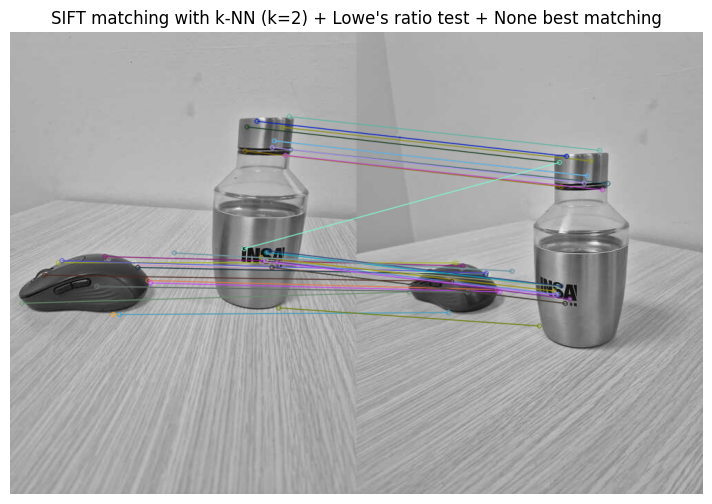

In [66]:
# Without RANSAC
main_sift_lowe(img_name_1="gourde_souris_1.jpeg", img_name_2="gourde_souris_2.jpeg", k=2, N=None)

Image size: 500 x 667
Image size: 500 x 667
Initial candidate matches (k-NN): 232
Matches after Lowe's ratio test: 37
Inliers after RANSAC: 18
Visualization of all correct matches


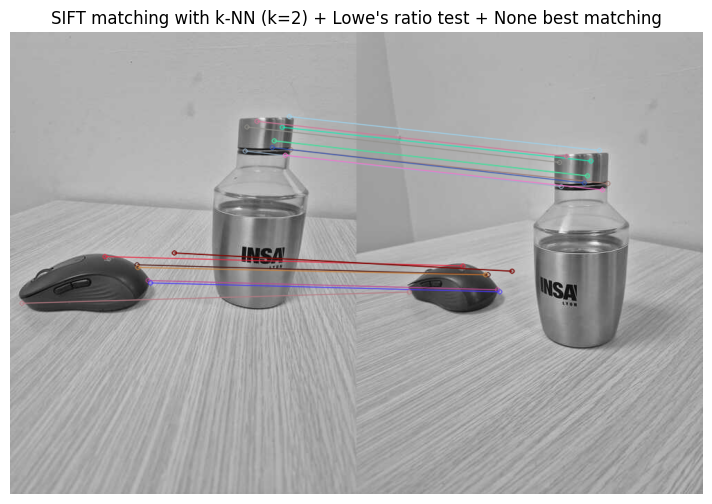

In [67]:
# With RANSAC
main_sift_lowe_ransac(img_name_1="gourde_souris_1.jpeg", img_name_2="gourde_souris_2.jpeg", k=2, N=None)

### Questions
**Q:** How many matches remain before and after
RANSAC?

**A:** 
- Before: 37
- After: 18

<br>

**Q:** Are the removed matches “visually correct”?

**A:** Some are visually correct and other don't. But after the RANSAC application, only visually good "matches" left.

<br>

**Q:** Why are some visually “good” matches rejected?

**A:** The model can be too rigid. Or the threshold used is restrictive, and even "good" matches can be rejected.

# 2- Influence of the reprojection threshold



### Task

Modify: ransacReprojThreshold = {1, 3, 5, 10}


Image size: 500 x 667
Image size: 500 x 667
Initial candidate matches (k-NN): 232
Matches after Lowe's ratio test: 37
Inliers after RANSAC: 10
Visualization of all correct matches


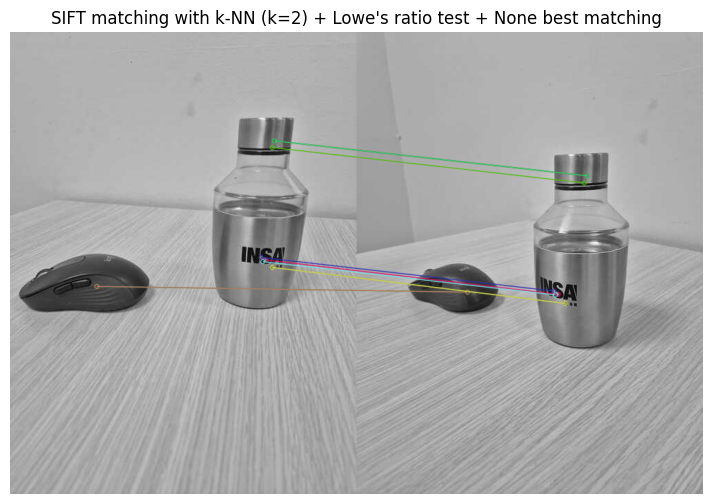

In [69]:
main_sift_lowe_ransac(img_name_1="gourde_souris_1.jpeg", img_name_2="gourde_souris_2.jpeg", k=2, N=None, ransacReprojThreshold=1.0)

Image size: 500 x 667
Image size: 500 x 667
Initial candidate matches (k-NN): 232
Matches after Lowe's ratio test: 37
Inliers after RANSAC: 13
Visualization of all correct matches


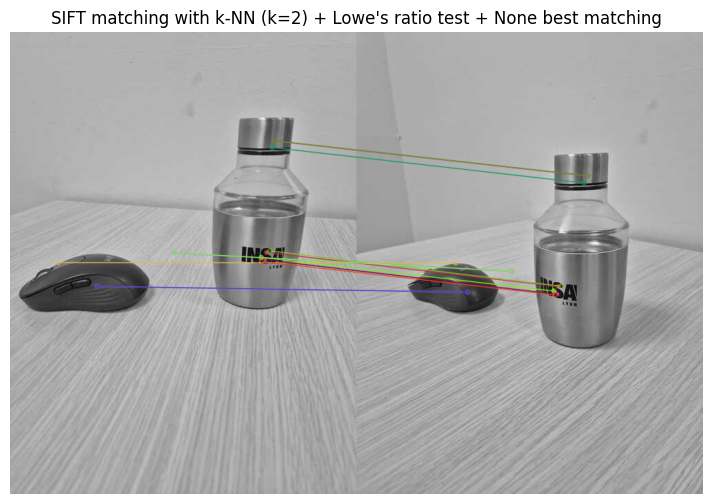

In [70]:
main_sift_lowe_ransac(img_name_1="gourde_souris_1.jpeg", img_name_2="gourde_souris_2.jpeg", k=2, N=None, ransacReprojThreshold=3.0)

Image size: 500 x 667
Image size: 500 x 667
Initial candidate matches (k-NN): 232
Matches after Lowe's ratio test: 37
Inliers after RANSAC: 18
Visualization of all correct matches


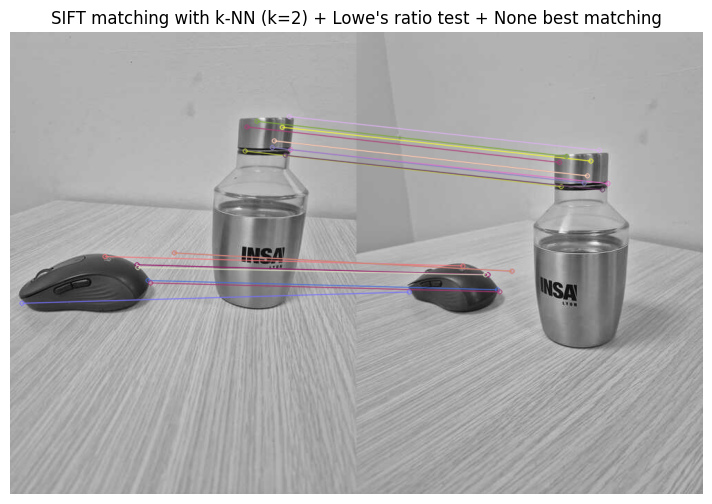

In [71]:
main_sift_lowe_ransac(img_name_1="gourde_souris_1.jpeg", img_name_2="gourde_souris_2.jpeg", k=2, N=None, ransacReprojThreshold=5.0)

Image size: 500 x 667
Image size: 500 x 667
Initial candidate matches (k-NN): 232
Matches after Lowe's ratio test: 37
Inliers after RANSAC: 24
Visualization of all correct matches


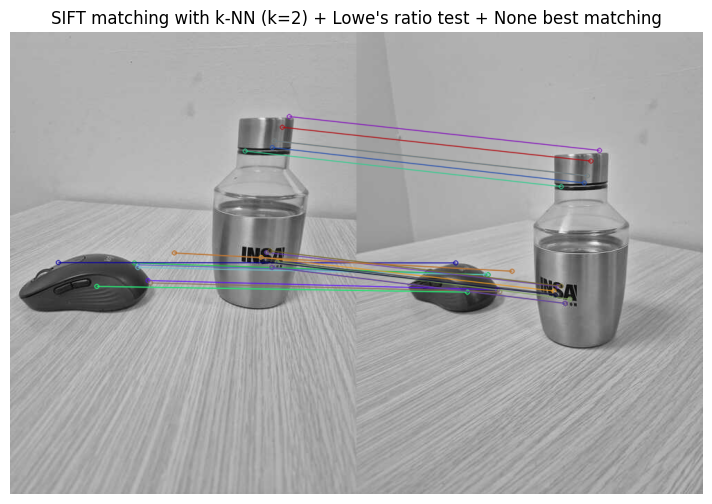

In [72]:
main_sift_lowe_ransac(img_name_1="gourde_souris_1.jpeg", img_name_2="gourde_souris_2.jpeg", k=2, N=None, ransacReprojThreshold=10.0)

### Questions
**Q:** How does the number of inliers change?

**A:** It changes the threshold to determine if a match is correct or not. It implies that the number of mathes will differ. Small ransacReprojThreshold will restrict the number of correct matches where a larger one will increase this number.

<br>

**Q:** What happens when the threshold is too small?

**A:** The number of rejected matches increase, it could be possible to have 0 matches kept after the RANSAC application.

<br>

**Q:** What happens when it is too large?

**A:** The RANSAC algorithm become useless, it becomes not enough restrictive.



# 3- Inlier ratio as a decision criterion


### Task

Compute and report:

inlier_ratio = num_inliers / num_matches
<br>

Test on:
- two images of the same object
- images of different objects



Image size: 500 x 667
Image size: 500 x 667
Initial candidate matches (k-NN): 232
Matches after Lowe's ratio test: 37
Inliers after RANSAC: 18
Visualization of all correct matches


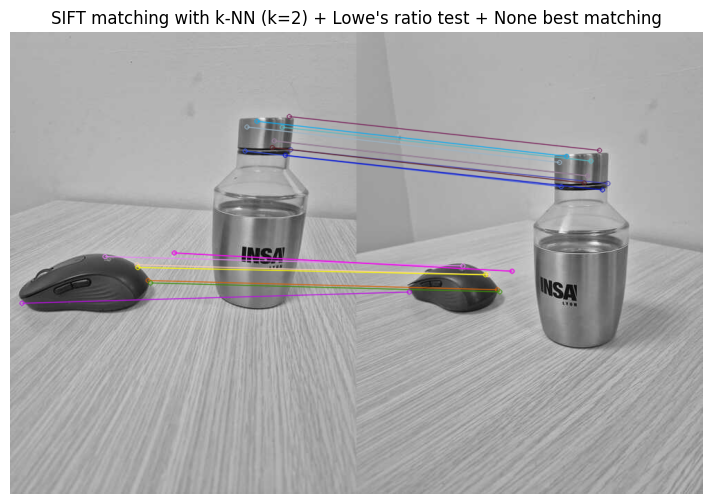

In [73]:
main_sift_lowe_ransac(img_name_1="gourde_souris_1.jpeg", img_name_2="gourde_souris_2.jpeg", k=2, N=None)

inlier ratio : 18/232 = 0.078

Image size: 500 x 667
Image size: 500 x 667
Initial candidate matches (k-NN): 232
Matches after Lowe's ratio test: 9
Inliers after RANSAC: 4
Visualization of all correct matches


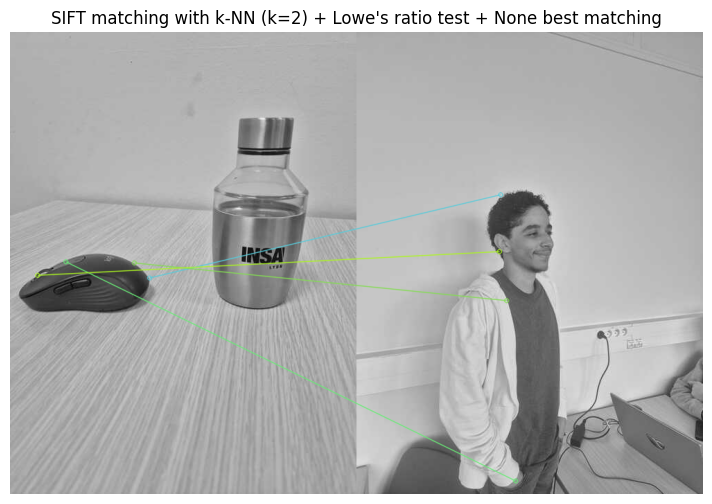

In [74]:
main_sift_lowe_ransac(img_name_1="gourde_souris_1.jpeg", img_name_2="lancelot_2.jpeg", k=2, N=None)

inlier ratio : 4/232 = 0.017

### Questions
**Q:** Is the inlier ratio higher for identical objects?

**A:** Yes, between 5 and 6 times compare to the different objects.

<br>

**Q:** Can you define a threshold to decide object identity?

**A:** Considering the test compare an image of a human with an image of two objects, this may be under representative. But I think a correct treshold would be 0.07 (7%)

<br>

**Q:** Does this threshold generalize across scenes?

**A:** Difficult to say, but yes I think so.


# 4 - RANSAC failure cases

### Task

Apply the code to the following situations:

- repetitive textures (brick wall, tiled floor)
- non-planar objects
- large viewpoint changes
- occlusions


Image size: 500 x 667
Image size: 828 x 1704
Initial candidate matches (k-NN): 232
Matches after Lowe's ratio test: 13
Inliers after RANSAC: 10
Visualization of all correct matches


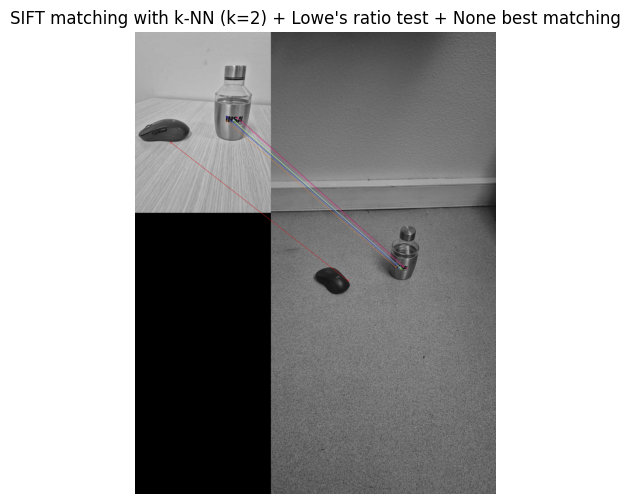

In [78]:
main_sift_lowe_ransac(img_name_1="gourde_souris_1.jpeg", img_name_2="gourde_souris_4.jpeg", k=2, N=None)

Image size: 648 x 373
Image size: 373 x 648
Initial candidate matches (k-NN): 998
Matches after Lowe's ratio test: 997
Inliers after RANSAC: 997
Visualizing top 50 matches


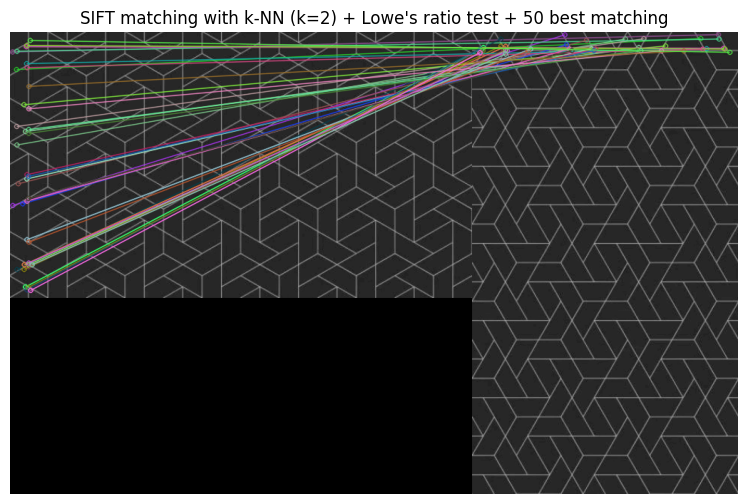

In [79]:
main_sift_lowe_ransac(img_name_1="motifs.png", img_name_2="motifs_rot.png", k=2, N=50)

### Questions
**Q:** Does RANSAC always find a valid homography?

**A:** Not always, this is pretty good for the "motifs.png" but not so good for the non-planar perpective modification.

<br>

**Q:** When does it fail completely?

**A:** If the geometry distorsion is maximum (big perpective change in a 3D space). As we can see in the example, the RANSAC does not perofrm very well on the perspective change, unless I kept the same plan and just change the scale.

<br>

**Q:** Why is the homography model inappropriate in some
cases?

**A:** The RANSAC is not adapted to non-planar objects and to big perspective modification. The 3D is a trap for the RANSA algorithm because the geometry of a plan is not the same that the 3D geometry.

# 5 - Breaking the homography assumption

### Task

Use two images:

- with strong depth variation
- or taken from very different viewpoints


Image size: 500 x 667
Image size: 500 x 667
Initial candidate matches (k-NN): 298
Matches after Lowe's ratio test: 7
Inliers after RANSAC: 4
Visualization of all correct matches


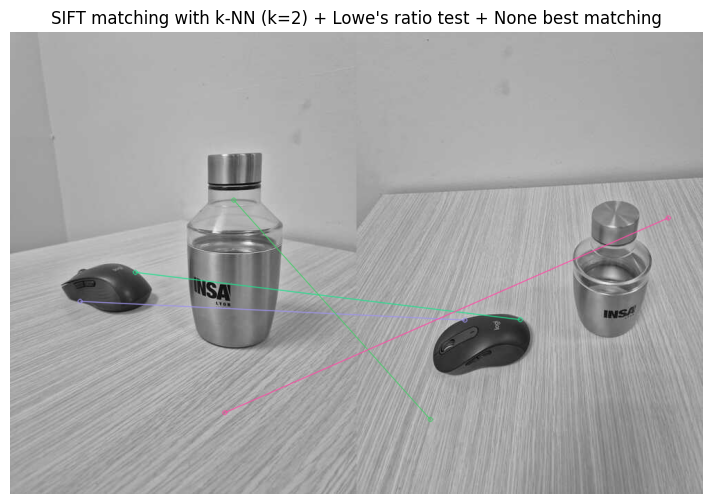

In [80]:
main_sift_lowe_ransac(img_name_1="gourde_souris_2.jpeg", img_name_2="gourde_souris_3.jpeg", k=2, N=None)

### Questions
**Q:** Why does RANSAC reject most matches?

**A:** It does not understand the geometry changes, and the switch of plan allow to have similar points but with an higher distance than in a plan. This higher distance allow RANSAC to reject the matches. 

<br>

**Q:** Which geometric assumption is violated?

**A:** The planarity assumption.

<br>

**Q:** Would a different model (e.g. fundamental matrix) be
more appropriate?

**A:** Yes, because the fundamental matrix model does not need of the planarity assumption. But it is sensitive to the noise and outliers.



# 6- How many matches are really needed?

### Task

Artificially reduce the number of input matches:

randomly keep only 30%, then 10%


In [92]:
import random as rd

"""
Parameters : 
img_name_1 : name of the first image
img_name_2 : name of the second image
k : number of closest neighboors kept after the algorithm application
N : number of best mathes : 5,10,20,30... or None (all the matches)
ratio_threshold : scalar value (between 0 and 1) that controls how distinct the best match must be compared to the second-best match.
sample_size: a % of the matches kept for the RANSAC application.
"""
def main_sift_lowe_ransac_sample(img_name_1, img_name_2, k, N, ratio_threshold = 0.75, ransacReprojThreshold=5.0, sample_size=30):
    ### Imgs loading + sift detection
    image_1 = load_img(img_name=img_name_1)
    img_1_kp, kp_1, des_1 = draw_keypoints(image_1, sift)

    image_2 = load_img(img_name=img_name_2)
    img_2_kp, kp_2, des_2 = draw_keypoints(image_2, sift)

    
    ### Retrieve candidate matches using k-nearest neighbor search (k = 2)
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches_knn = bf.knnMatch(des_1, des_2, k=k) 
    print(f"Initial candidate matches (k-NN): {len(matches_knn)}")

    ### Lowe's ratio test (relative similarity) - reject ambiguous matches
    ratio_threshold = ratio_threshold
    good_matches = []

    for m, n in matches_knn:
        if m.distance < ratio_threshold * n.distance:
            good_matches.append(m)

    print(f"Matches after Lowe's ratio test: {len(good_matches)}")


    # sampling 
    number_of_elem = int(len(good_matches) * sample_size / 100)
    matches_sample = rd.sample(good_matches, number_of_elem)
    if not matches_sample:
        print("matches_sample is empty, the sampling size is to small")
        return False

    # Extract matched point coordinates
    pts1 = np.float32([kp_1[m.queryIdx].pt for m in matches_sample])
    pts2 = np.float32([kp_2[m.trainIdx].pt for m in matches_sample])


    # RANSAC: estimate homography / verifies geometry
    H, inlier_mask = cv2.findHomography(
        pts1,
        pts2,
        method=cv2.RANSAC,
        ransacReprojThreshold=ransacReprojThreshold
    )

    inlier_mask = inlier_mask.ravel().astype(bool)

    # Keep only inlier matches
    inlier_matches = [
        m for i, m in enumerate(matches_sample) if inlier_mask[i]
    ]

    print(f"Inliers after RANSAC: {len(inlier_matches)}")


    ### Keep only the N ( 5, 10, 20, 30, 50...) best matches (lowest distance)
    inlier_matches = sorted(inlier_matches, key=lambda x: x.distance)
    top_matches = inlier_matches[:N]


    ### Visualisation
    if N is None :
        print("Visualization of all correct matches")
        top_matches = inlier_matches
    else :
        print(f"Visualizing top {len(top_matches)} matches")

    img_matches = cv2.drawMatches(
        image_1, kp_1,
        image_2, kp_2,
        top_matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure(figsize=(14, 6))
    plt.imshow(img_matches, cmap="gray")
    plt.title(f"SIFT matching with k-NN (k=2) + Lowe's ratio test + {N} best matching")
    plt.axis("off")
    plt.show()
        
    
    

In [93]:
main_sift_lowe_ransac_sample(img_name_1="gourde_souris_1.jpeg", img_name_2="gourde_souris_3.jpeg", k=2, N=None, sample_size=10)

Image size: 500 x 667
Image size: 500 x 667
Initial candidate matches (k-NN): 232
Matches after Lowe's ratio test: 6
matches_sample is empty, the sampling size is to small


False

In [94]:
main_sift_lowe_ransac_sample(img_name_1="gourde_souris_1.jpeg", img_name_2="gourde_souris_3.jpeg", k=2, N=None, sample_size=30)

Image size: 500 x 667
Image size: 500 x 667
Initial candidate matches (k-NN): 232
Matches after Lowe's ratio test: 6


error: OpenCV(4.13.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:390: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'


### Questions
**Q:** Does RANSAC still find a stable homography?

**A:** No, I got an error during the execution

<br>

**Q:** What is the minimum number of matches required?

**A:** the required minimum is 4:

error: OpenCV(4.13.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:390: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography

<br>

**Q:** Why does RANSAC become unstable with too few inliers?

**A:** RANSAC relies on random sampling of minimal subsets. With to few inliers, the probability of having a good subset is low, and it become more sensitive to noise.


# 7- Visual interpretation of inliers

### Task

Visualize:

- all Lowe matches
- only RANSAC inliers


Image size: 500 x 667
Image size: 500 x 667
Initial candidate matches (k-NN): 232
Matches after Lowe's ratio test: 37
Visualization of all correct matches


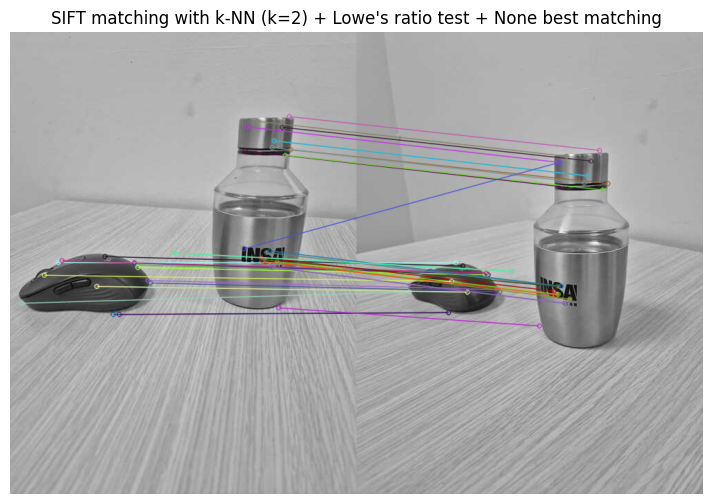

In [98]:
main_sift_lowe(img_name_1="gourde_souris_1.jpeg", img_name_2="gourde_souris_2.jpeg", k=2, N=None)

Image size: 500 x 667
Image size: 500 x 667
Initial candidate matches (k-NN): 232
Matches after Lowe's ratio test: 37
Inliers after RANSAC: 18
Visualization of all correct matches


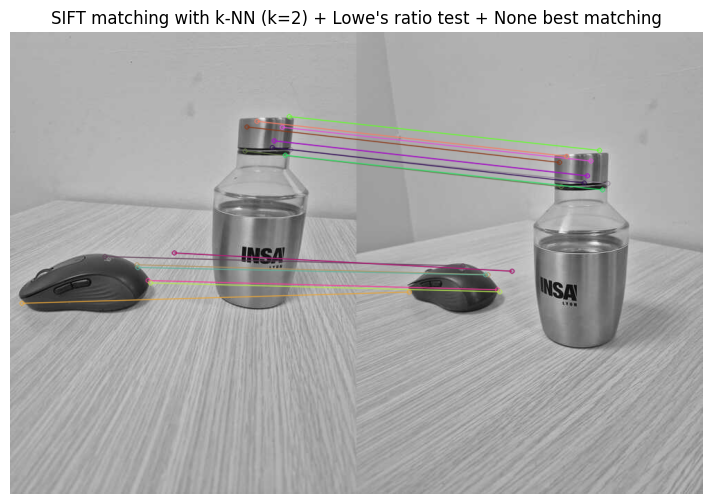

In [101]:
main_sift_lowe_ransac(img_name_1="gourde_souris_1.jpeg", img_name_2="gourde_souris_2.jpeg", k=2, N=None)

### Questions
**Q:** What spatial pattern do inliers form?

**A:** A Straight line.

<br>

**Q:** Are inliers uniformly distributed?

**A:** No.


# 8 - Same descriptor, different Geometry

### Task

Match two different objects with similar textures

Image size: 1500 x 2000
Image size: 1500 x 2000
Initial candidate matches (k-NN): 380
Matches after Lowe's ratio test: 17
Inliers after RANSAC: 4
Visualization of all correct matches


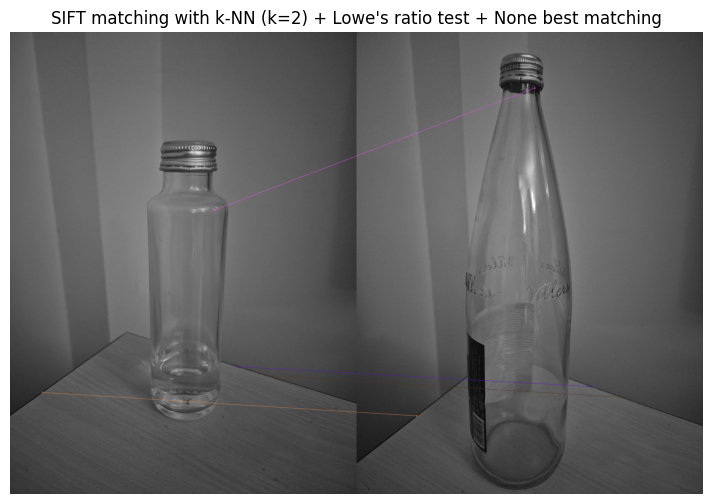

In [103]:
main_sift_lowe_ransac(img_name_1="botle_1.jpeg", img_name_2="botle_2.jpeg", k=2, N=None)

### Questions
**Q:** Are matches correctly found?

**A:** no, there is no correct matches

<br>

**Q:** Does RANSAC accept or reject them?

**A:** RANSAC reject them :
- 17 matches after Lowe's ratio
- 4 after RANSAC

<br>

**Q:** What does this tell you about appearance vs geometry?

**A:** The geometry is much more important than the appearance and the texture of objects.
